In [1]:
import rebound  # will only work if rebound is installed in your python distro
import numpy as np  #  math stuff 
import matplotlib.pyplot as plt  # generic plotting stuff 
%matplotlib inline 


### Rebound Numerical problem for Problem set #6

### Exploring how an inward migrating planet can capture asteroids into resonance, producing star grazers or ejecting asteroids from the star system

Following this migration example
https://github.com/hannorein/rebound/blob/main/ipython_examples/Forces.ipynb

And 
https://github.com/hannorein/rebound/blob/main/ipython_examples/CloseEncounters.ipynb on dealing with encounters 

If a planet migrates inward then mean motion orbital resonances also move inward.  These can 
strongly influence asteroids that are originally orbiting inside the planet's orbit.
 
We start by placing a particle external to a mean motion resonance with the planet.
We integrate the system so that the planet (and its orbital resonances) slowly drifts inward.
Our goal is to explore what happens to the particle as it enters the resonance. 

The particle can be captured into resonance or it can jump across the resonance. 
If the particle is captured then its eccentricity will increase and its semi-major axis
will remain locked, drifting with the planet's semi-major axis.  As the particle's eccentricity increases,
it can hit the planet, hit the star or be ejected from the system. 

Choose one of the following to explore:

- How fast can you drift before a particular resonance is unlikely to capture a particle?
- How does the planet eccentricity affect the outcomes or the capture probability?
- What are the likely final states for the particle?  

            
Some phenonema: 
    
- Resonances such as the 3:1 or 4:1 can cause star grazers if the planet's eccentricity is not low. An example is shown below.
- Resonances such as the 3:2 or 4:3 or 5:2 might cause the particle to impact the planet. 
- If the planet drifts too quickly, weaker resonances will fail to capture. 
- Particles can be ejected from the system or might possibly wind up in a stable orbit outside the planet's orbit.

Note we now check for collisions.


In [44]:
sim = rebound.Simulation() # create rebound simulation !
sim.G = 1.0
sim.integrator = "ias15"  # integrate carefully!
sim.add(m=1.) # add a central star 
sim.add(m=1.0e-3,e=0.05, a=1.) # add a planet, particle 1, note initial eccentricity 
sim.add(m=0,e=0.0001,a=0.45) # add a test particle , particle 2, massless, not initial semi-major axis
sim.move_to_com()
collision_distance =0.01  # minimum distance to determine collisions
sim.exit_min_distance = collision_distance  # exit simulation if there is a collision between two objects at this distance

# Nbody units: 1 orbit of planet is equal to 2pi

# set up an additional force that causes the planet to migrate
ps = sim.particles
tau = 1e4  # drift timescale for planet
def migrationForce(reb_sim):
    ip=1 # only migrate the planet, inward
    # do a velocity dependent drift rate that depends on timescale tau 
    ps[1].ax -= ps[ip].vx/tau
    ps[1].ay -= ps[ip].vy/tau
    ps[1].az -= ps[ip].vz/tau
    
sim.additional_forces = migrationForce  # let rebound know we have an additional force 
sim.force_is_velocity_dependent = 1     # let rebound know that the additional force is velocity dependent
sim.collision = "direct"  # type of collisions 

# compute distance between two particles 
def dist(p1,p2):
    r = np.sqrt( (p1.x - p2.x)**2 + (p1.y - p2.y)**2 + (p1.z - p2.z)**2 )
    return r

In [46]:

p_max = 1000*2*np.pi # number of orbital periods for integration 
Nout = int(1e3) # number of output times 
a_p = np.zeros(Nout)  # storage arrays for planet
e_p = np.zeros(Nout)
a_t = np.zeros(Nout) # for particle
e_t = np.zeros(Nout)

# integrate and store eccentricity and semi-major axes 
times = np.linspace(0.,p_max,Nout)  # times to integrate to

for i,time in enumerate(times):
    try:
        sim.integrate(time)
        a_p[i] = sim.particles[1].a 
        e_p[i] = sim.particles[1].e 
        a_t[i] = sim.particles[2].a 
        e_t[i] = sim.particles[2].e 
    except rebound.Encounter as error:  #check for collisions!
        print(error)
        print('at t=', time)
        r02 = dist(sim.particles[0],sim.particles[2])  # figure out which collisions happened!
        r12 = dist(sim.particles[1],sim.particles[2])
        if (r02 <= colision_distance):
            print("collided with star")
        if (r12 <= colision_distance):
            print("collided with planet")
        break



Two particles had a close encounter (d<exit_min_distance).
at t= 6050.474740247008
collided with star


In [48]:
rmax_p = a_p*(1+e_p)  # apocenter  of planet 
rmin_p = a_p*(1-e_p)  # pericenter of planet 
rmax_t = a_t*(1+e_t)  # apocenter of particle 
rmin_t = a_t*(1-e_t)  # pericenter of particle 

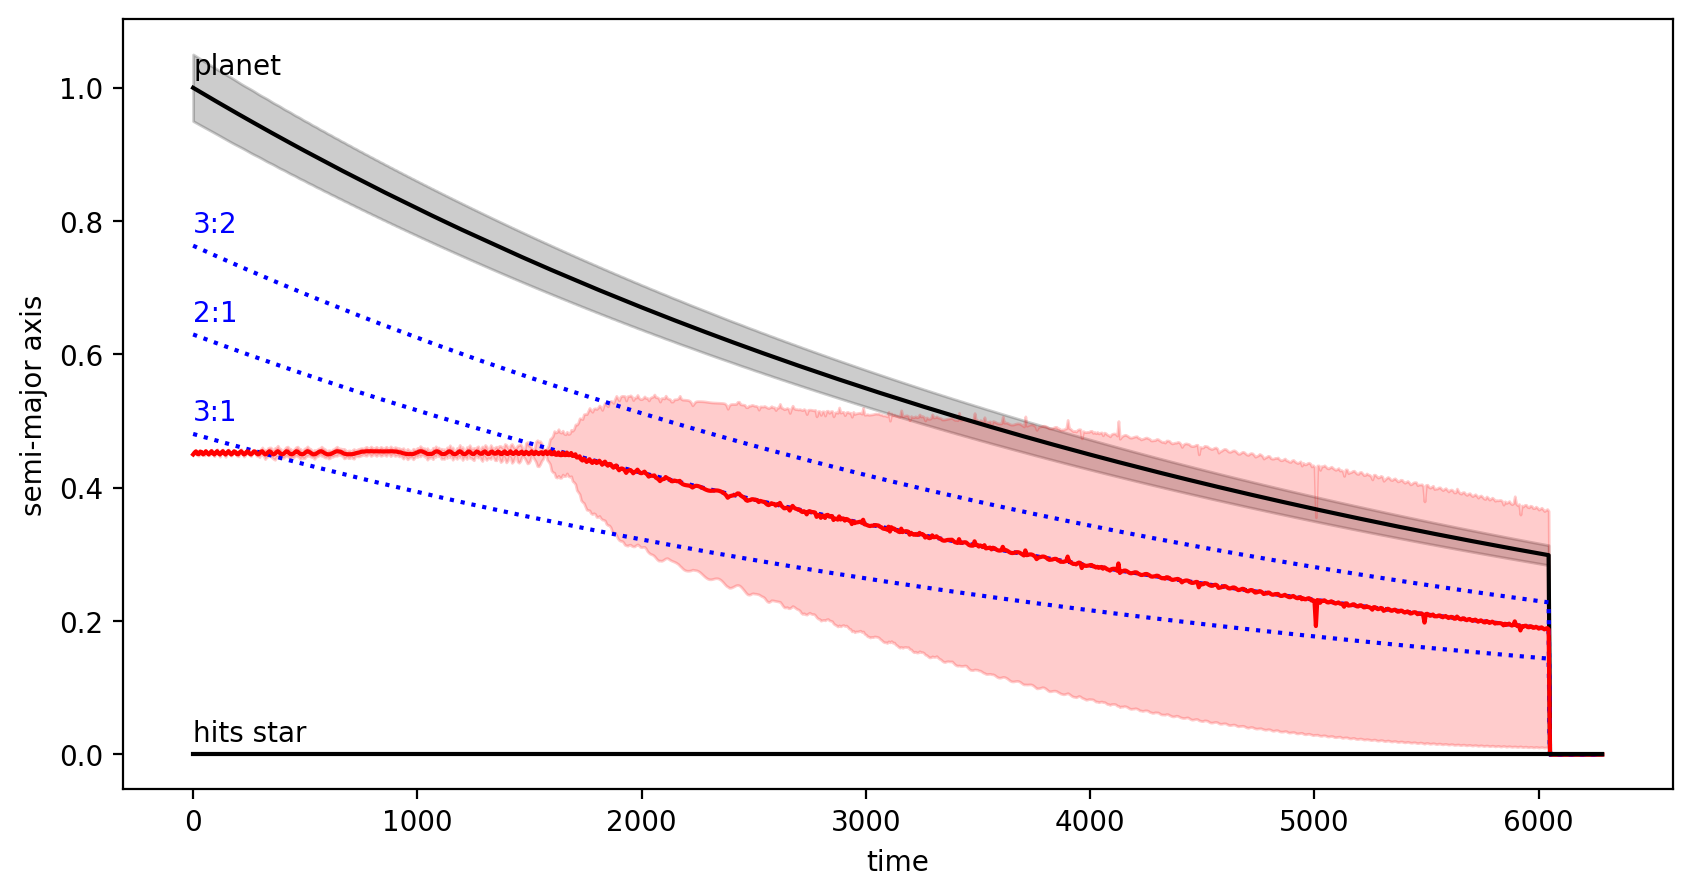

In [50]:
fig = plt.figure(figsize=(10,5),dpi=200)
ax = plt.subplot(111)
ax.set_xlabel("time")
ax.set_ylabel("semi-major axis")
ax.plot(times, a_p, 'k-'); # planet's semi-major axis 
ax.fill_between(times, rmin_p,rmax_p, alpha=0.2, color='black'); # planet's apo and pericenter

# plot resonance locations 
da = 0.02
r_32 = (2./3.)**(2.0/3.0)
ax.plot(times, a_p*r_32, 'b:'); ax.text(0,a_p[0]*r_32 + da,'3:2', color='blue')
r_2 = (1./2.)**(2.0/3.0)
ax.plot(times, a_p*r_2, 'b:'); ax.text(0,a_p[0]*r_2 + da,'2:1', color='blue')
r_3 = (1./3.)**(2.0/3.0)
ax.plot(times, a_p*r_3, 'b:'); ax.text(0,a_p[0]*r_3 + da,'3:1', color='blue')


ax.fill_between(times, rmin_t,rmax_t,alpha = 0.2,color='red');  # fill in apocenter to pericenter
ax.plot(times, a_t, 'r-');
ax.plot(times, 0*times, 'k-')
ax.text(0,0+da,'hits star')
ax.text(0,1+da,'planet')

plt.show()

The red region shows particle apocenters and pericenters.  Here the particle skipped over the 3:1 resonance, and was captured into the 2:1 resonance.  It's eccentricity increased.  It crossed the planet's orbit prior to becoming a star grazer.    Eventually it hit the star and we stopped the simulation!